# I. Setting up

In [231]:
import pandas as pd
import requests, zipfile, io
import glob
import os
import xml.etree.ElementTree as et
from string import ascii_letters
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [232]:
df = pd.read_excel('../data/measurements2.xlsx')

In [233]:
df.head(10)

distance  consume  speed  temp_inside  temp_outside specials gas_type  AC  \
0      28.0      5.0     26         21.5            12      NaN      E10   0   
1      12.0      4.2     30         21.5            13      NaN      E10   0   
2      11.2      5.5     38         21.5            15      NaN      E10   0   
3      12.9      3.9     36         21.5            14      NaN      E10   0   
4      18.5      4.5     46         21.5            15      NaN      E10   0   
5       8.3      6.4     50         21.5            10      NaN      E10   0   
6       7.8      4.4     43         21.5            11      NaN      E10   0   
7      12.3      5.0     40         21.5             6      NaN      E10   0   
8       4.9      6.4     26         21.5             4      NaN      E10   0   
9      11.9      5.3     30         21.5             9      NaN      E10   0   

   rain  sun  refill liters refill gas  
0     0    0           45.0        E10  
1     0    0            NaN        NaN  
2     0    0            NaN        NaN  
3     0    0            NaN        NaN  
4     0    0            NaN        NaN  
5     0    0            NaN        NaN  
6     0    0            NaN        NaN  
7     0    0            NaN        NaN  
8     0    0            NaN        NaN  
9     0    0            NaN        NaN

In [234]:
df['gas_type'].unique()

array(['E10', 'SP98'], dtype=object)

In [235]:
df['specials'].unique()

array([nan, 'AC rain', 'AC', 'rain', 'snow', 'AC snow',
       'half rain half sun', 'sun', 'AC sun', 'sun ac', 'ac', 'AC Sun',
       'ac rain'], dtype=object)

In [236]:
df['AC'].unique()

array([0, 1])

In [237]:
df['refill gas'].unique()

array(['E10', nan, 'SP98'], dtype=object)

In [238]:
df.loc[df["refill gas"] == "E10"]

distance  consume  speed  temp_inside  temp_outside specials gas_type  \
0        28.0      5.0     26         21.5            12      NaN      E10   
139      16.1      5.4     24         21.5             7     rain      E10   
171      44.4      4.8     38         21.5             8      NaN      E10   
234      19.0      4.5     29         22.5            10      NaN      E10   
325      16.6      3.7     49         22.0            17      NaN      E10   

     AC  rain  sun  refill liters refill gas  
0     0     0    0           45.0        E10  
139   0     1    0           38.0        E10  
171   0     0    0           38.3        E10  
234   0     0    0           39.0        E10  
325   0     0    0           37.7        E10

In [239]:
df.describe()

distance     consume       speed  temp_inside  temp_outside  \
count  388.000000  388.000000  388.000000   376.000000    388.000000   
mean    19.652835    4.912371   41.927835    21.929521     11.358247   
std     22.667837    1.033172   13.598524     1.010455      6.991542   
min      1.300000    3.300000   14.000000    19.000000     -5.000000   
25%     11.800000    4.300000   32.750000    21.500000      7.000000   
50%     14.600000    4.700000   40.500000    22.000000     10.000000   
75%     19.000000    5.300000   50.000000    22.500000     16.000000   
max    216.100000   12.200000   90.000000    25.500000     31.000000   

               AC        rain         sun  refill liters  
count  388.000000  388.000000  388.000000      13.000000  
mean     0.077320    0.123711    0.082474      37.115385  
std      0.267443    0.329677    0.275441       8.587282  
min      0.000000    0.000000    0.000000      10.000000  
25%      0.000000    0.000000    0.000000      37.600000  
50%      0.000000    0.000000    0.000000      38.000000  
75%      0.000000    0.000000    0.000000      39.000000  
max      1.000000    1.000000    1.000000      45.000000

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   consume        388 non-null    float64
 2   speed          388 non-null    int64  
 3   temp_inside    376 non-null    float64
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill liters  13 non-null     float64
 11  refill gas     13 non-null     object 
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


###### Let's see what we have:
- The distance seems to be in (km), the consume in (liters), the speed in (km/h), the temperature in (ºC).
- We have information about two types of fuel, lead free 98 and lead free 95 plus a maximum of 10% of ethanol.
- The range in distance, considering the mean is much larger than the range in consume. Besides the standard deviation is quite big here. We need to check this (I.a).
- The information about the refillment seems disposable, as we cannot know if the total consume of a trip was estimated before of after refueling the car, and there are no changes in the fuel than was loaded. We will discard these columns (I.b).
- We have 6 columns with parameters about the weather and its impact on the behaviour of the car, like if the air-conditioning (AC) was on. The purpose here will be to determine if these parameters have a noticeable impact on the fuel consumption (III.a).

### I.a Check the relation between distance and consume

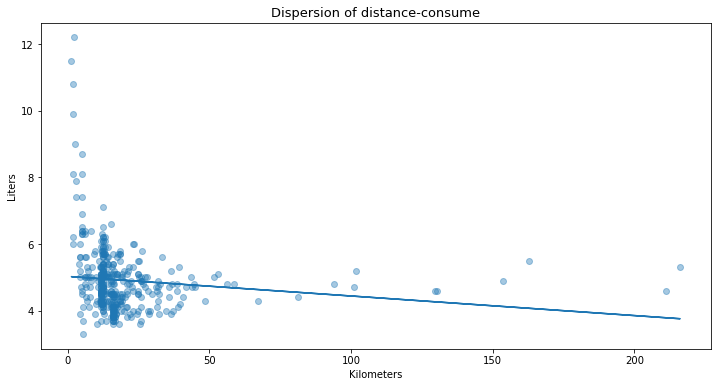

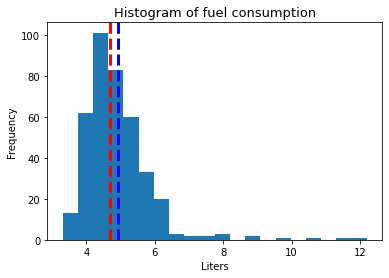

In [241]:
x = df.distance.values
y = df.consume.values
m, b = np.polyfit(x, y, 1)
fig, ax = plt.subplots(figsize=(12, 6))

plt.scatter(x, y, alpha=0.4)
plt.title('Dispersion of distance-consume', size=13)
plt.xlabel('Kilometers')
plt.ylabel('Liters')
plt.plot(x, m*x + b)
plt.show();

plt.hist(y, bins=20)
plt.axvline(np.median(y),
            c="red",
            linewidth= 3.,
            linestyle='--')
plt.axvline(np.mean(y),
            c="blue",
            linewidth= 3.,
            linestyle='--')
plt.title('Histogram of fuel consumption', size=13)
plt.xlabel('Liters')
plt.ylabel('Frequency')
plt.show();

In [242]:
df.consume.mean()

4.912371134020614

In [329]:
df.head(3)

distance  consume  speed  temp_inside  temp_outside gas_type  AC  rain  sun
1      12.0      4.2     30         21.5            13      E10   0     0    0
2      11.2      5.5     38         21.5            15      E10   0     0    0
6       7.8      4.4     43         21.5            11      E10   0     0    0

In [244]:
df.consume.quantile(0.95)

6.3649999999999975

In [245]:
df.distance.mean()

19.65283505154639

In [246]:
df.distance.quantile(0.95)

42.93999999999996

In [255]:
indexNames1 = df[df['distance'] >= 12.45].index
df.drop(indexNames1, inplace=True)

indexNames2 = df[df['consume'] >= 6.364].index
df.drop(indexNames2, inplace=True)

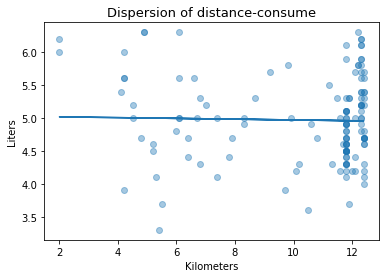

In [259]:
x = df.distance.values
y = df.consume.values
plt.scatter(x, y, alpha=0.4)
plt.title('Dispersion of distance-consume', size=13)
plt.xlabel('Kilometers')
plt.ylabel('Liters')
plt.plot(x, m*x + b)
plt.show();

##### So now we have removed the 0.05 % of the data that was giving us wrong measures. Of course we are suppossing that all the cars had performed equally, which is impossible, but it's useful for estimating the average consumption of fuel.

### I.b Remove unnecessary columns and clean NaNs.

In [260]:
df.drop(['refill liters', 'refill gas'], axis=1, inplace=True)

In [263]:
df.isnull().sum()

distance          0
consume           0
speed             0
temp_inside       4
temp_outside      0
specials        108
gas_type          0
AC                0
rain              0
sun               0
dtype: int64

In [277]:
df['temp_inside'].median()

21.5

In [278]:
df['temp_inside'].mode()

0    21.5
dtype: float64

In [279]:
df['temp_inside'].mean()

21.83955223880597

In [280]:
df['temp_inside'] = df['temp_inside'].fillna(21.5)

In [282]:
df['specials'].unique()

array([nan, 'AC rain', 'AC', 'rain', 'snow', 'sun'], dtype=object)

In [285]:
df[df['specials'] == 'AC rain'].sample()

distance  consume  speed  temp_inside  temp_outside specials gas_type  \
204       8.7      5.3     28         22.5            12  AC rain     SP98   

     AC  rain  sun  
204   1     1    0

In [290]:
df[df['specials'].isna()].sample()

distance  consume  speed  temp_inside  temp_outside specials gas_type  AC  \
52      11.6      4.2     61         21.5             7      NaN     SP98   0   

    rain  sun  
52     0    0

In [291]:
df.drop(['specials'], axis=1, inplace=True)

# II. Enriching the data

## II.a Fuel price

##### Let's get now some aditional information about the prices of the fuel and the potential impact on the environment, as the car performance is not the only parameter we can consider for our analysis.

In [292]:
r = requests.get('https://donnees.roulez-eco.fr/opendata/jour')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("../data/")

##### From the URL above we can get an .xml file containing the last available prices of both types of fuels in every gas station at France. We don't know where is the company operating, but from that info we can get a map with the cheapest operational areas according to the type of fuel, which may hold potential interest for the company.

##### For now let's just extract the average price of each type of fuel so we can get a general estimation.

In [293]:
os.chdir("../data")

In [294]:
xml_file = glob.glob("*.xml")
xtree = et.parse(xml_file[0])
xroot = xtree.getroot()

In [295]:
name = []
for node in xroot.iter('prix'): 
    name.append(node.attrib.get("nom"))

In [296]:
price = []
for node in xroot.iter('prix'): 
    price.append(node.attrib.get("valeur"))

In [299]:
price_dict = {"name":name, "price":price}
price = pd.DataFrame(price_dict, columns=("name","price"))

In [306]:
price.name.unique()

array(['Gazole', 'SP95', 'SP98', 'GPLc', 'E10', 'E85'], dtype=object)

In [318]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33183 entries, 0 to 33182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    33183 non-null  object
 1   price   33183 non-null  object
dtypes: object(2)
memory usage: 518.6+ KB


In [320]:
price['price'] = price['price'].astype('int')

In [322]:
price['price'] = price['price'] / 1000

In [324]:
price.groupby(['name']).mean() # euros/litre

price
name            
E10     1.817104
E85     0.799041
GPLc    0.930988
Gazole  1.769265
SP95    1.849589
SP98    1.901638

In [325]:
price_e10 = 1.817104
price_sp98 = 1.901638

## II.b Environmental impact

##### Now let's try to get an estimation of the expectable amount of CO2 emissions for each fuel.

In [326]:
os.chdir("../notebooks")

##### Let's estimate now the emissions per kilometer for the SP98 fuel:
- 1 liter of petrol weighs 750 grammes. Petrol consists for 87% of carbon, or 652 grammes of carbon per liter of petrol. In order to combust this carbon to CO2, 1740 grammes of oxygen is needed. The sum is then 652 + 1740 = 2392 grammes of CO2/liter of petrol.
- An average consumption of 5 liters/100 km then corresponds to 5 l x 2392 g/l / 100 (per km) = 120 g CO2/km.

##### If we estimate that 10% of the composition is ethanol, the average decrease of carbon emissions compared to the regular gasoline is of 2%:
- 2392 * 0.98 = 2344.16 grammes of CO2/liter of fuel.
- An average consumption of 5 liters/100 km then corresponds to 5 l x 2344.16 g/l / 100 (per km) = 117.2 g CO2/km.

In [327]:
co2_e10 = 2.34416
co2_sp98 = 2.392

# III. Back to the main dataframe

## III.a Data related to the environmental conditions

##### We can manually estimate an average 5 % loss of power due to having the AC system on, developing a range according to the diferences in the temperatures.

##### After checking the correlation, we will see if any other parameters are relevant.

In [328]:
df.head(1)

distance  consume  speed  temp_inside  temp_outside gas_type  AC  rain  sun
1      12.0      4.2     30         21.5            13      E10   0     0    0

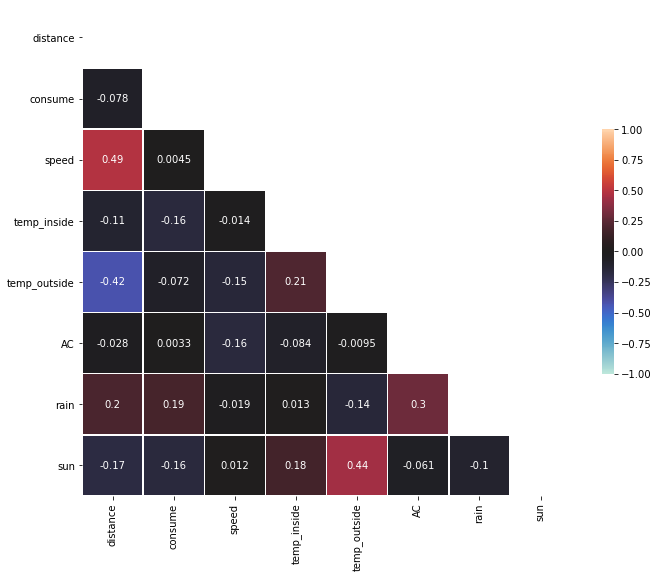

In [330]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

## III.b Cost and CO2 impact estimation per trip

In [333]:
df['cost'] = df.apply(lambda row: (row['consume'] * price_e10) if row['gas_type'] == 'E10' else (row['consume'] * price_sp98), axis=1)
df['co2'] = df.apply(lambda row: (row['consume'] * co2_e10) if row['gas_type'] == 'E10' else (row['consume'] * co2_sp98), axis=1)

In [334]:
df.head(1)

distance  consume  speed  temp_inside  temp_outside gas_type  AC  rain  \
1      12.0      4.2     30         21.5            13      E10   0     0   

   sun      cost       co2  
1    0  7.631837  9.845472

In [336]:
df.groupby(['gas_type']).cost.mean()

gas_type
E10     9.066722
SP98    9.398846
Name: cost, dtype: float64

In [337]:
df.groupby(['gas_type']).co2.mean()

gas_type
E10     11.69655
SP98    11.82246
Name: co2, dtype: float64

In [344]:
estim_red_cost = round(100 - ((9.066722 / 9.398846) * 100), 2)
estim_red_co2 = round(100 - ((11.69655 / 11.82246) * 100), 2)

In [347]:
print(f'The average cost reduction by using E10 instead of SP98 is of {estim_red_cost} %.')
print(f'The average CO2 reduction by using E10 instead of SP98 is of {estim_red_co2} %.')

The average cost reduction by using E10 instead of SP98 is of 3.53 %.
The average CO2 reduction by using E10 instead of SP98 is of 1.07 %.


##### Therefore, the best option with the available data is to use E10 fuel. ⚡⚡

In [348]:
df.to_csv('../data/clean_df.csv', index=False)